# Regularization

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

import numpy as np
import seaborn as sns

import plotly.graph_objects as go
from plotly.io import renderers
renderers.default = 'png'
from plotly.subplots import make_subplots

from utils.design import plotly_main_layout, plotly_main_subplot_layout

___
### Dropout

- Reduces the overall activation (fewer elements in the weighted sums)
- Solutions for weight compansation:
    - Scale up the weights during training
    - Scale down the weights during testing
- Effects:
    - Prevents a single node from learning too much
    - Forces the model to have distributed representations
    - Make the model less reliant on individual nodes and thus more stable
- Observations: 
    - Generally requires more training
    - Can decrease training accuracy but increases generalization
    - Usually works better on deep than shallow networks
    - Debate about applying to convulutional layers
    - Works better with sufficient data, so it is unnecessary for huge datasets

In [20]:
prob = 0.5

dropout = nn.Dropout(p=prob)
x = torch.ones(10)

y = dropout(x)
print(f'Input:        {x}')
print(f'Output:       {y}')
print(f'Scale Down:   {y*(1-prob)}')

Input:        tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Output:       tensor([2., 0., 2., 0., 0., 0., 2., 2., 2., 0.])
Scale Down:   tensor([1., 0., 1., 0., 0., 0., 1., 1., 1., 0.])


In [31]:
dropout.eval()
y = dropout(x)
print(f'Evaluation Mode (All are Active): {y}')
print(f'<!> torch.nn.functional.dropout is not deactivated in .eval()')
print(f'<!> torch.nn.functional.dropout(x, training=False) can deactivate')

Evaluation Mode (All are Active): tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
<!> torch.nn.functional.dropout is not deactivated in .eval()
<!> torch.nn.functional.dropout(x, training=False) can deactivate


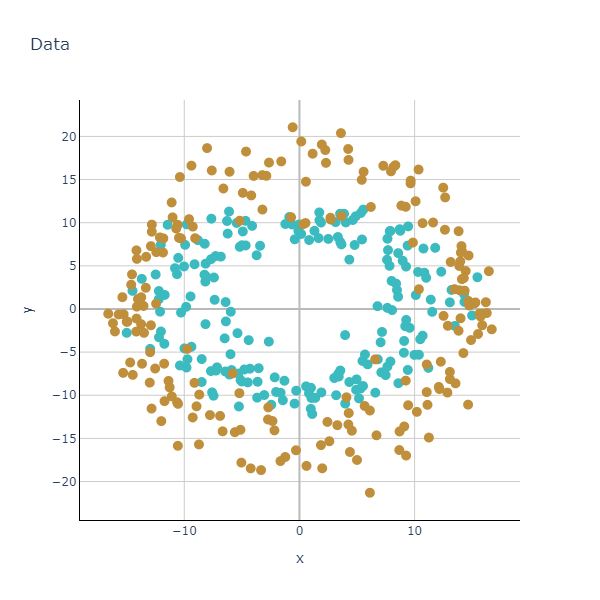

In [ ]:
# create data
nPerClust = 200

th = np.linspace(0,4*np.pi,nPerClust)
r1 = 10
r2 = 15

# generate data
a = [ r1*np.cos(th) + np.random.randn(nPerClust)*3 ,
      r1*np.sin(th) + np.random.randn(nPerClust) ]
b = [ r2*np.cos(th) + np.random.randn(nPerClust) ,
      r2*np.sin(th) + np.random.randn(nPerClust)*3 ]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

# concatanate into a matrix
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

fig_data = go.Figure()
fig_data.add_trace(go.Scatter(
    x=data[np.where(labels==0)[0],0], y=data[np.where(labels==0)[0],1],
    mode='markers', marker=dict(color='#3bbbbf', size=10), showlegend=False,
))
fig_data.add_trace(go.Scatter(
    x=data[np.where(labels==1)[0],0], y=data[np.where(labels==1)[0],1],
    mode='markers', marker=dict(color='#bf8f3b', size=10), showlegend=False,
))
plotly_main_layout(fig_data, title='Data', width=600)

In [43]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batchsize = int(train_data.tensors[0].shape[0] / 4)
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [85]:
class ModelClass(nn.Module):
    def __init__(self, dropoutRate):
        super().__init__()

        # Layers
        self.input = nn.Linear(2, 128)
        self.hidden = nn.Linear(128, 128)
        self.output = nn.Linear(128, 1)

        # Parameters
        self.dropoutRate = dropoutRate

    
    def forward(self, x):

        x = F.relu(self.input(x))
        x = F.dropout(x, p=self.dropoutRate, training=self.training)

        x = F.relu(self.hidden(x))
        x = F.dropout(x, p=self.dropoutRate, training=self.training)

        x = self.output(x)

        return x
    

def createNewModel(dropoutRate):
    ANNQC = ModelClass(dropoutRate=dropoutRate)
    lossfun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(ANNQC.parameters(), lr=0.002)

    return ANNQC, lossfun, optimizer


def trainModel(ANNQC, lossfun, optimizer, numepochs=1000):

    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):
        ANNQC.train()

        batchAcc = []
        for X, y in train_loader:

            yHat = ANNQC(X)
            loss = lossfun(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchAcc.append(100*torch.mean(((yHat > 0) == y).float()).item())

        trainAcc.append(float(np.mean(batchAcc)))
        
        ANNQC.eval()
        X, y = next(iter(test_loader))
        yHat = ANNQC(X)
        testAcc.append(100*torch.mean(((yHat > 0.5) == y).float()).item())
    
    return trainAcc, testAcc


def smooth(x, k=5):
    return np.convolve(x, np.ones(k)/k, mode='same')

In [81]:
dropoutRate = 0
numepochs = 1000
ANNQC, lossfun, optimizer = createNewModel(dropoutRate=dropoutRate)
trainAcc, testAcc = trainModel(ANNQC, lossfun, optimizer, numepochs)

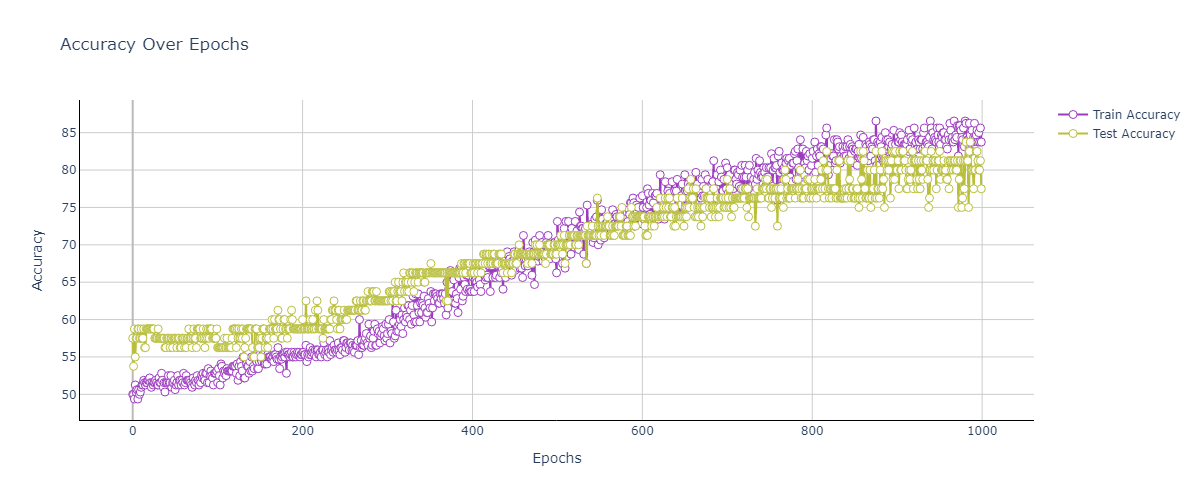

In [98]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=list(range(numepochs)), y=trainAcc, name='Train Accuracy',
    marker=dict(color='white', size=8, line=dict(color='#9c3bbf', width=1)), line=dict(color='#9c3bbf'), mode='markers+lines'
))
fig.add_trace(go.Scatter(
    x=list(range(numepochs)), y=testAcc, name='Test Accuracy',
    marker=dict(color='white', size=8, line=dict(color='#b9bf3b', width=1)), line=dict(color='#b9bf3b'), mode='markers+lines'
))
plotly_main_layout(fig, title='Accuracy Over Epochs', x='Epochs', y='Accuracy', width=1200, height=500)

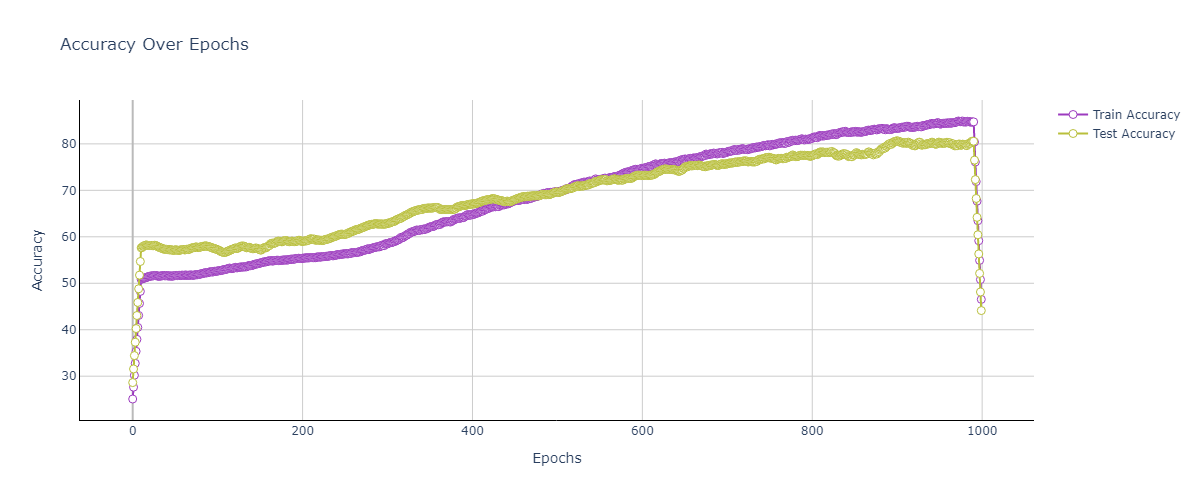

In [100]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=list(range(numepochs)), y=smooth(trainAcc, k=20), name='Train Accuracy',
    marker=dict(color='white', size=8, line=dict(color='#9c3bbf', width=1)), line=dict(color='#9c3bbf'), mode='markers+lines'
))
fig.add_trace(go.Scatter(
    x=list(range(numepochs)), y=smooth(testAcc, k=20), name='Test Accuracy',
    marker=dict(color='white', size=8, line=dict(color='#b9bf3b', width=1)), line=dict(color='#b9bf3b'), mode='markers+lines'
))
plotly_main_layout(fig, title='Accuracy Over Epochs', x='Epochs', y='Accuracy', width=1200, height=500)

In [116]:
dropoutRates = np.arange(10)/10
results = np.zeros((len(dropoutRates),2))

for di in range(len(dropoutRates)):

    # create and train the model
    ANNQC,lossfun,optimizer = createNewModel(dropoutRates[di])
    trainAcc,testAcc = trainModel(ANNQC, lossfun, optimizer)

    # store accuracies from last 100 epochs
    results[di,0] = np.mean(trainAcc[-100:])
    results[di,1] = np.mean(testAcc[-100:])

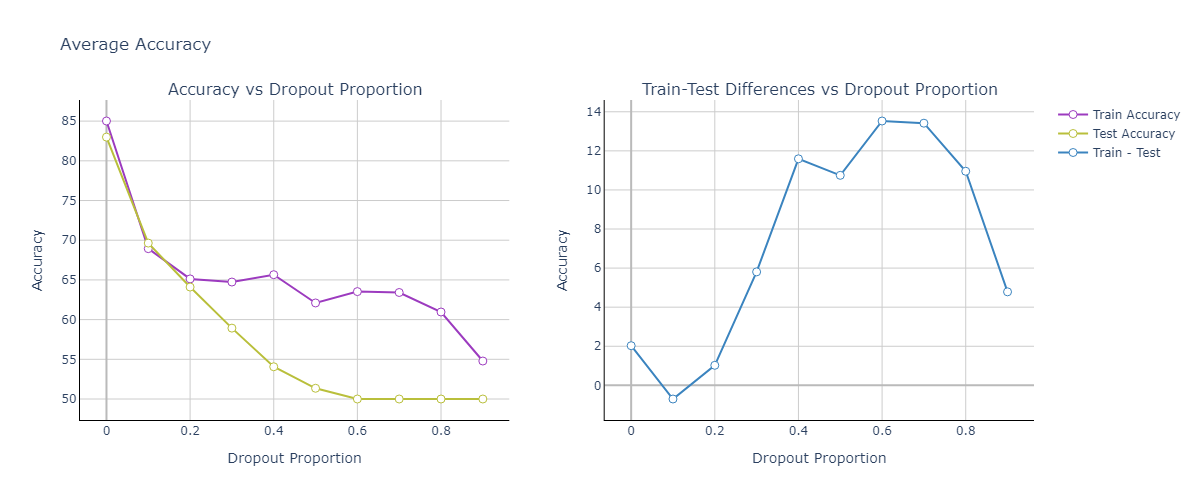

In [117]:
fig = make_subplots(rows=1, cols=2, subplot_titles=['Accuracy vs Dropout Proportion', 'Train-Test Differences vs Dropout Proportion'])

fig.add_trace(go.Scatter(
    x=dropoutRates, y=results[:,0], name='Train Accuracy',
    marker=dict(color='white', size=8, line=dict(color='#9c3bbf', width=1)), line=dict(color='#9c3bbf'), mode='markers+lines'
), row=1, col=1)
fig.add_trace(go.Scatter(
    x=dropoutRates, y=results[:,1], name='Test Accuracy',
    marker=dict(color='white', size=8, line=dict(color='#b9bf3b', width=1)), line=dict(color='#b9bf3b'), mode='markers+lines'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=dropoutRates, y=-np.diff(results, axis=1)[:,0], name='Train - Test',
    marker=dict(color='white', size=8, line=dict(color='#3b84bf', width=1)), line=dict(color='#3b84bf'), mode='markers+lines'
), row=1, col=2)

plotly_main_subplot_layout(fig, title='Average Accuracy', x='Dropout Proportion', y='Accuracy', width=1200, height=500)

In [ ]:

# plot the experiment results
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(dropoutRates,results,'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train','Test'])

ax[1].plot(dropoutRates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()

___
### Loss Regularization

- Goal of DL: $\textbf{W} = \underset{\textbf{W}}{\text{arg min }} \mathcal{J}$
- Cost Function: $\mathcal{J} = \dfrac{1}{n} \sum_{i=1}^n \mathcal{L}(\hat{y}_i, y_i)$
- Regularized Cost Function: $\mathcal{J} = \dfrac{1}{n} \sum_{i=1}^n \mathcal{L}(\hat{y}_i, y_i) + [\text{ l1 | l2 }]$
    - $\text{l1} = \lambda ||\textbf{w}||$
        - $\text{l1}$: Lasso Regularizations creates sparse weights by setting some to 0
    - $\text{l2} = \lambda ||\textbf{w}||^2_2 = \lambda [\textbf{w}^\text{T}\textbf{w}]$
        - $\text{l2}$: Rigde Regularizations (wright decay), that shrink all weights, especially larger ones
    - $\text{l1} + \text{l2}$: Elastic net

In [119]:
iris = sns.load_dataset('iris')
data = torch.tensor(iris[iris.columns[0:4]].values).float()
labels = torch.zeros(len(data), dtype=torch.long)
labels[iris['species'] == 'versicolor'] = 1
labels[iris['species'] == 'virginica'] = 2

# Train test split
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, train_size=0.8)

# PyTorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# DataLoader objects
train_loader = DataLoader(train_data, shuffle=True, batch_size=12)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

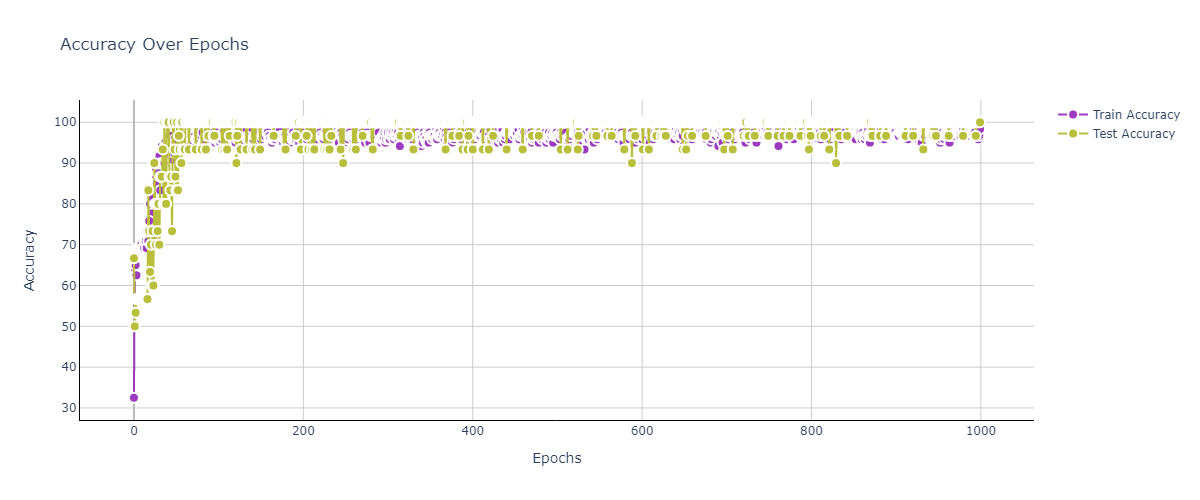

In [121]:
def createANewModel(L2lambda):
    # model architecture
    ANNiris = nn.Sequential(
        nn.Linear(4,64),   
        nn.ReLU(),         
        nn.Linear(64,64),  
        nn.ReLU(),         
        nn.Linear(64,3),   
    )

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANNiris.parameters(), lr=0.005, weight_decay=L2lambda)

    return ANNiris, lossfun, optimizer


def trainTheModel():

    # initialize accuracies as empties
    trainAcc = []
    testAcc  = []
    losses   = []

    # loop over epochs
    for epochi in range(numepochs):

        ANNiris.train()

        batchAcc  = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = ANNiris(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute training accuracy just for this batch
            batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item())
            batchLoss.append(loss.item())

        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))

        # test accuracy
        ANNiris.eval()
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        predlabels = torch.argmax(ANNiris(X), axis=1)
        testAcc.append(100*torch.mean((predlabels == y).float()).item())

    return trainAcc, testAcc, losses


numepochs = 1000
L2lambda = .01
ANNiris, lossfun, optimizer = createANewModel(L2lambda)
trainAcc, testAcc, losses = trainTheModel()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=list(range(numepochs)), y=trainAcc, name='Train Accuracy',
    marker=dict(color='#9c3bbf', size=10, line=dict(color='white', width=2)), mode='markers+lines'
))
fig.add_trace(go.Scatter(
    x=list(range(numepochs)), y=testAcc, name='Test Accuracy',
    marker=dict(color='#b9bf3b', size=10, line=dict(color='white', width=2)), mode='markers+lines'
))
plotly_main_layout(fig, title='Accuracy Over Epochs', x='Epochs', y='Accuracy', width=1200, height=500)

In [130]:
accuracyResultsTrain.shape

(1000, 10)

In [125]:
# range of L2 regularization amounts
l2lambdas = np.linspace(0,.1,10)

# initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs,len(l2lambdas)))
accuracyResultsTest  = np.zeros((numepochs,len(l2lambdas)))

# loop over batch sizes
for li in range(len(l2lambdas)):

  # create and train a model
  ANNiris,lossfun,optimizer = createANewModel(l2lambdas[li])
  trainAcc,testAcc,losses = trainTheModel()

  # store data
  accuracyResultsTrain[:,li] = smooth(trainAcc,10)
  accuracyResultsTest[:,li]  = smooth(testAcc,10)

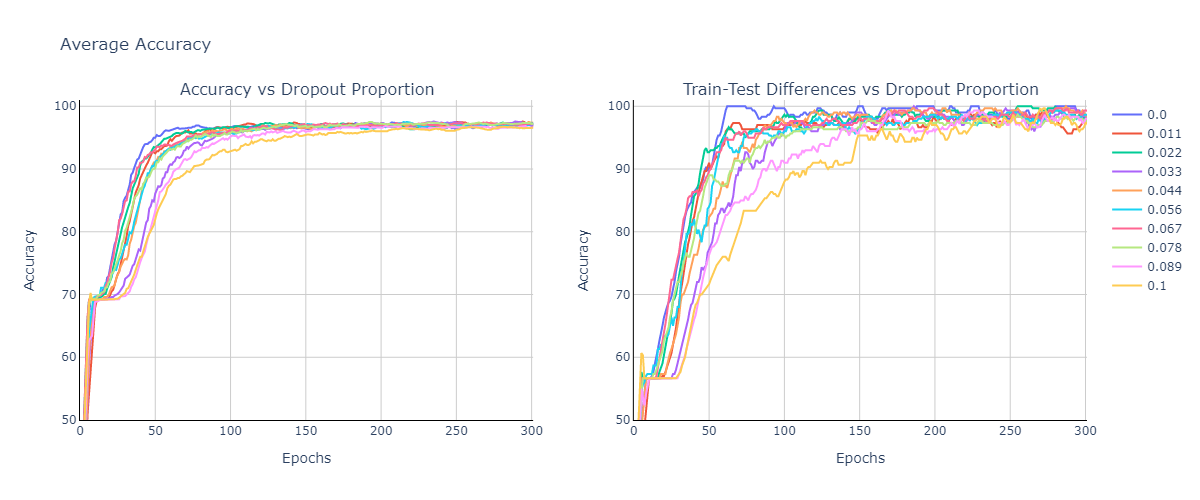

In [153]:
fig = make_subplots(rows=1, cols=2, subplot_titles=['Accuracy vs Dropout Proportion', 'Train-Test Differences vs Dropout Proportion'])

for i, acc_label in zip(range(accuracyResultsTrain.shape[-1]), l2lambdas):
    fig.add_trace(go.Scatter(
        x=list(range(numepochs)), y=accuracyResultsTrain[:,i], name=f'{acc_label:.2}', mode='lines'
    ), row=1, col=1)

for i, acc_label in zip(range(accuracyResultsTest.shape[-1]), l2lambdas):
    fig.add_trace(go.Scatter(
        x=list(range(numepochs)), y=accuracyResultsTest[:,i], name=f'{acc_label:.2}', mode='lines', 
        showlegend=False
    ), row=1, col=2)

plotly_main_subplot_layout(fig, title='Average Accuracy', x='Epochs', y='Accuracy', width=1200, height=500, x_range=[0, 301], y_range=[50, 101])

___
### Data Augmentation

___
### x

___
### x

___
### x

___
### x

___
### x

___
### x